In [106]:
import os
import json
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

from networks import ConvNetSmall
from advertorch.attacks import GradientSignAttack, LinfPGDAttack

device = "cpu"
ROOT = Path("")

In [113]:
# CIFAR10
checkpoint_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/small/tune_zoo_cifar10_small_hyperparameter_10_fixed_seeds")
data_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/small/tune_zoo_cifar10_small_hyperparameter_10_fixed_seeds/dataset.pt")
data_root = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/CIFAR10")

In [132]:
# MNIST
checkpoint_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/MNIST/tune_zoo_mnist_hyperparameter_10_fixed_seeds")
data_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/MNIST/tune_zoo_mnist_hyperparameter_10_fixed_seeds/dataset.pt")
data_root = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/MNIST")

In [133]:
model_list_path = os.path.join(data_root, "PGD", "hyp-10-f")

In [134]:
dataset = torch.load(data_path)["testset"]

In [135]:
with open(os.path.join(model_list_path, 'model_list.txt'), "r") as items:
    model_paths = items.readlines()

    for i, l in enumerate(model_paths):
        model_paths[i] = l.replace("\n", "")

In [136]:
# Define subsets of testset used for each of the n_models models
generator = torch.Generator().manual_seed(0)
imgs_per_model = len(dataset) / 50
split = [int(imgs_per_model) for i in range(50)]
remainder = len(dataset) - sum(split)
split[-1] += remainder

subsets = random_split(dataset, split, generator=generator)

In [124]:
subset = subsets[0]
aux_loader = DataLoader(dataset=subset, batch_size=len(subset), shuffle=False)
for cln_data, true_labels in aux_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


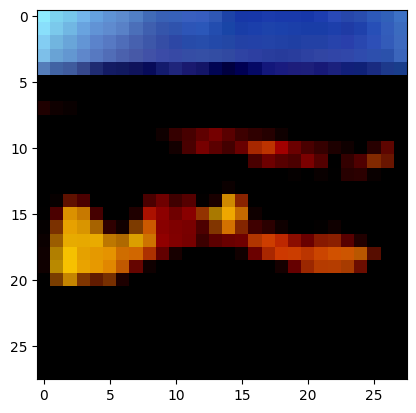

In [128]:
plt.imshow(np.moveaxis(cln_data[4].detach().cpu().numpy(), 0, 2))

In [142]:
images = torch.tensor((), device=device)
labels = torch.tensor((), device=device)

for i, path in enumerate(model_paths):
    model_config_path = os.path.join(checkpoint_path, path, "params.json")
    config_model = json.load(open(model_config_path,))

    model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=config_model["model::dropout"],
        init_type=config_model["model::init_type"]
    )
    
    try:
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    except RuntimeError:
        model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=0,
        init_type=config_model["model::init_type"]
        )
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    model.to(device)
        
    subset = subsets[i]
    aux_loader = DataLoader(dataset=subset, batch_size=len(subset), shuffle=False)
    for cln_data, true_labels in aux_loader:
        break
    cln_data, true_labels = cln_data.to(device), true_labels.to(device)
    # plt.imshow(np.moveaxis(cln_data[9].detach().cpu().numpy(), 0, 2))
    
    adversary=LinfPGDAttack(
        model,
        loss_fn=nn.CrossEntropyLoss(reduction="sum"),
        eps=1.0,
        nb_iter=3,
        eps_iter=2.0,
        rand_init=True,
        clip_min=0.0,
        clip_max=1.0,
        targeted=False
    )
    adv_images = adversary.perturb(cln_data, true_labels)

    images = torch.cat((images, adv_images))
    labels = torch.cat((labels, true_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


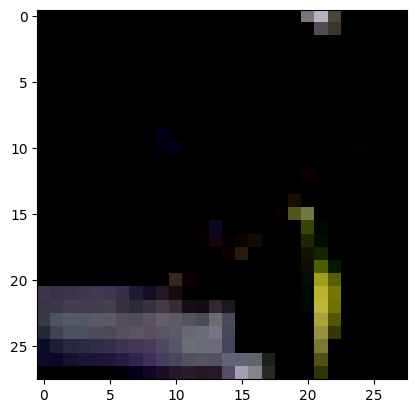

In [123]:
plt.imshow(np.moveaxis(adv_images[9].detach().cpu().numpy(), 0, 2))

In [143]:
perturbed_dataset = TensorDataset(images, labels)

In [144]:
loader = DataLoader(dataset=perturbed_dataset, batch_size=10, shuffle=False)

In [145]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# eps = 2
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

In [35]:
# eps = 4
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.43337408335208893 0.1781


In [45]:
# eps=8
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.4284177385210991 0.177


In [61]:
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.42977814666032793 0.178


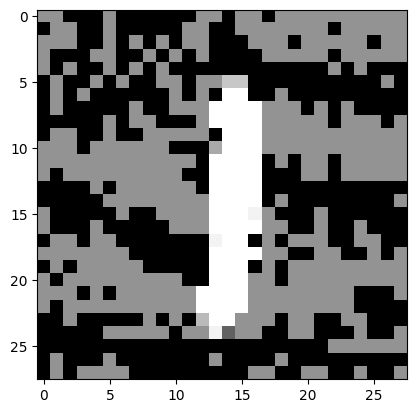

In [62]:
plt.imshow(np.moveaxis(perturbed_dataset[0][0].detach().cpu().numpy(), 0, 2), cmap="gray")

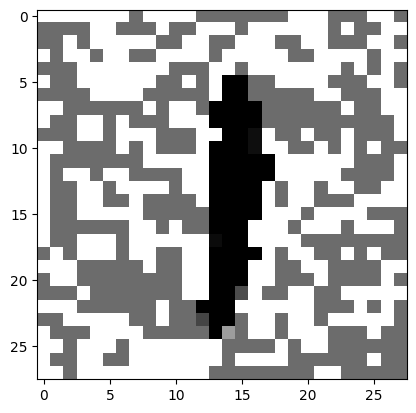

In [19]:
plt.imshow(np.moveaxis(perturbed_dataset2[0][0].detach().cpu().numpy(), 0, 2), cmap="gray_r")

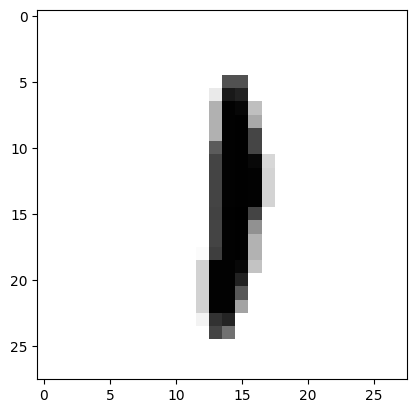

In [80]:
plt.imshow(np.moveaxis(dataset[0][0].detach().cpu().numpy(), 0, 2), cmap="gray_r")